In [1]:
from s2widthFast import WidthModel
import numpy as np
from tqdm import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.style.use('style.mplstyle')

In [2]:
# Create model with physical constants
Dl = 40.45   # cm^2/s
vd = 0.13    # cm/µs
C = 0.775
dC = 0.01
model = WidthModel(Dl, vd, C=C, dC=dC)
widths=np.linspace(1,6000,200)

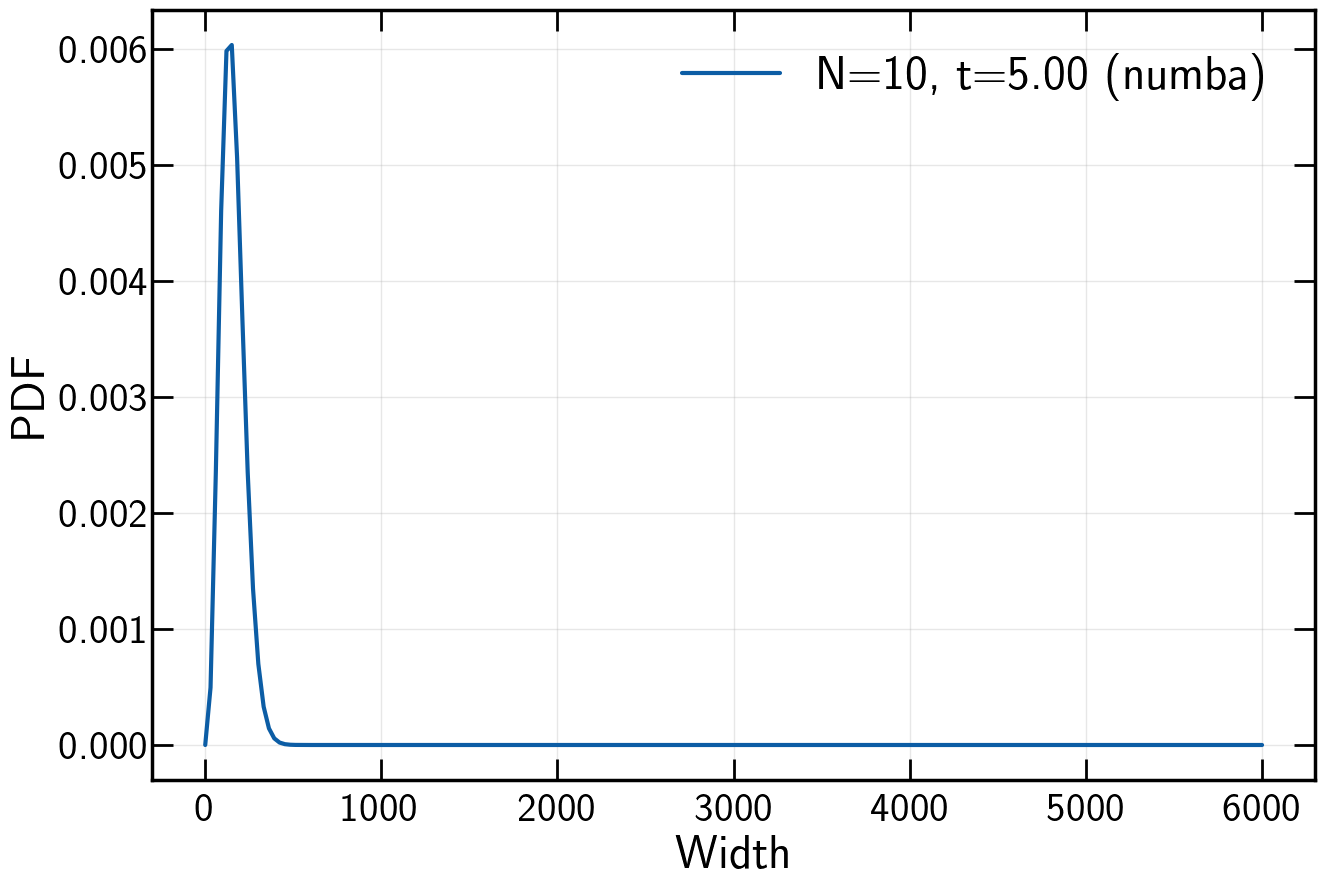

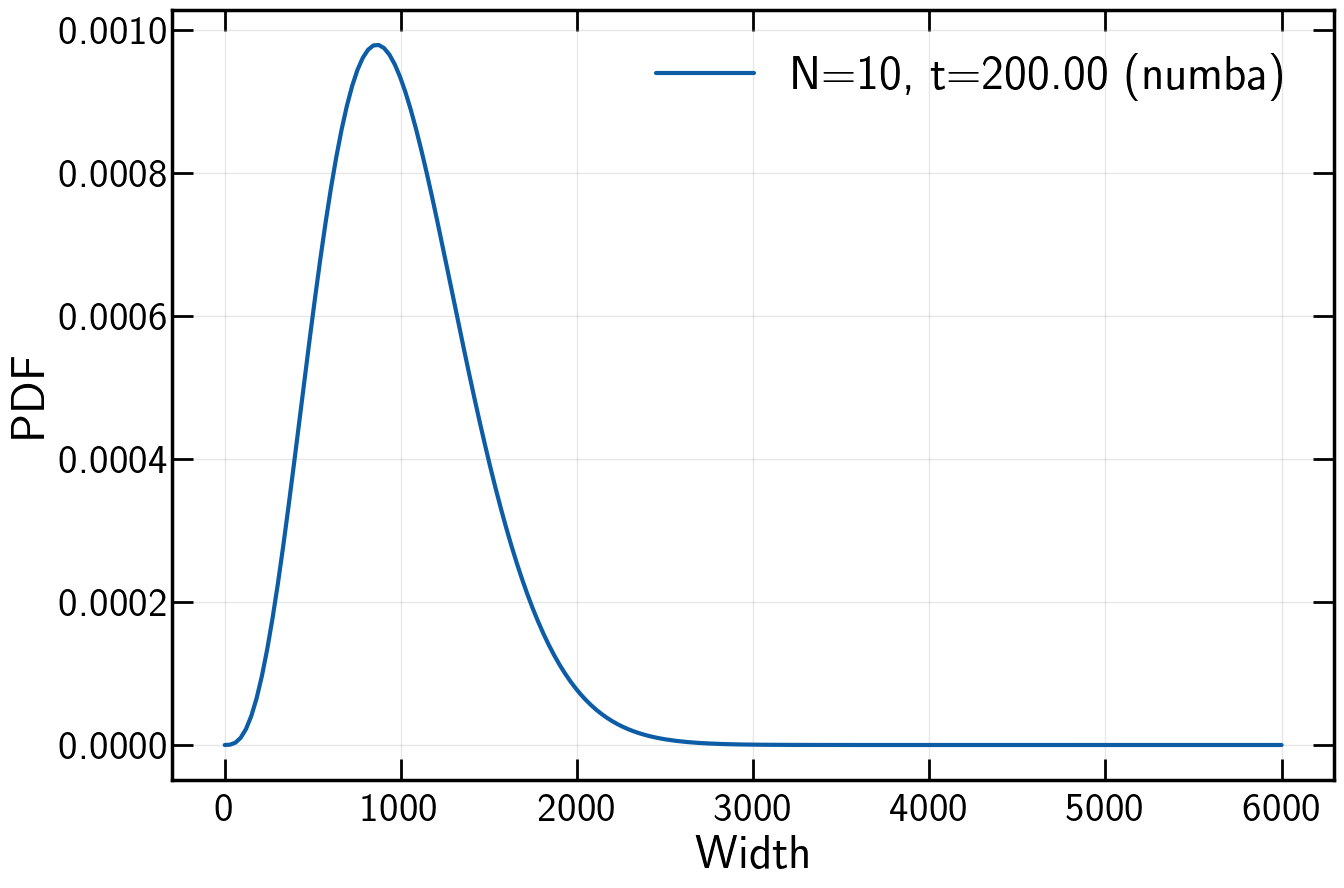

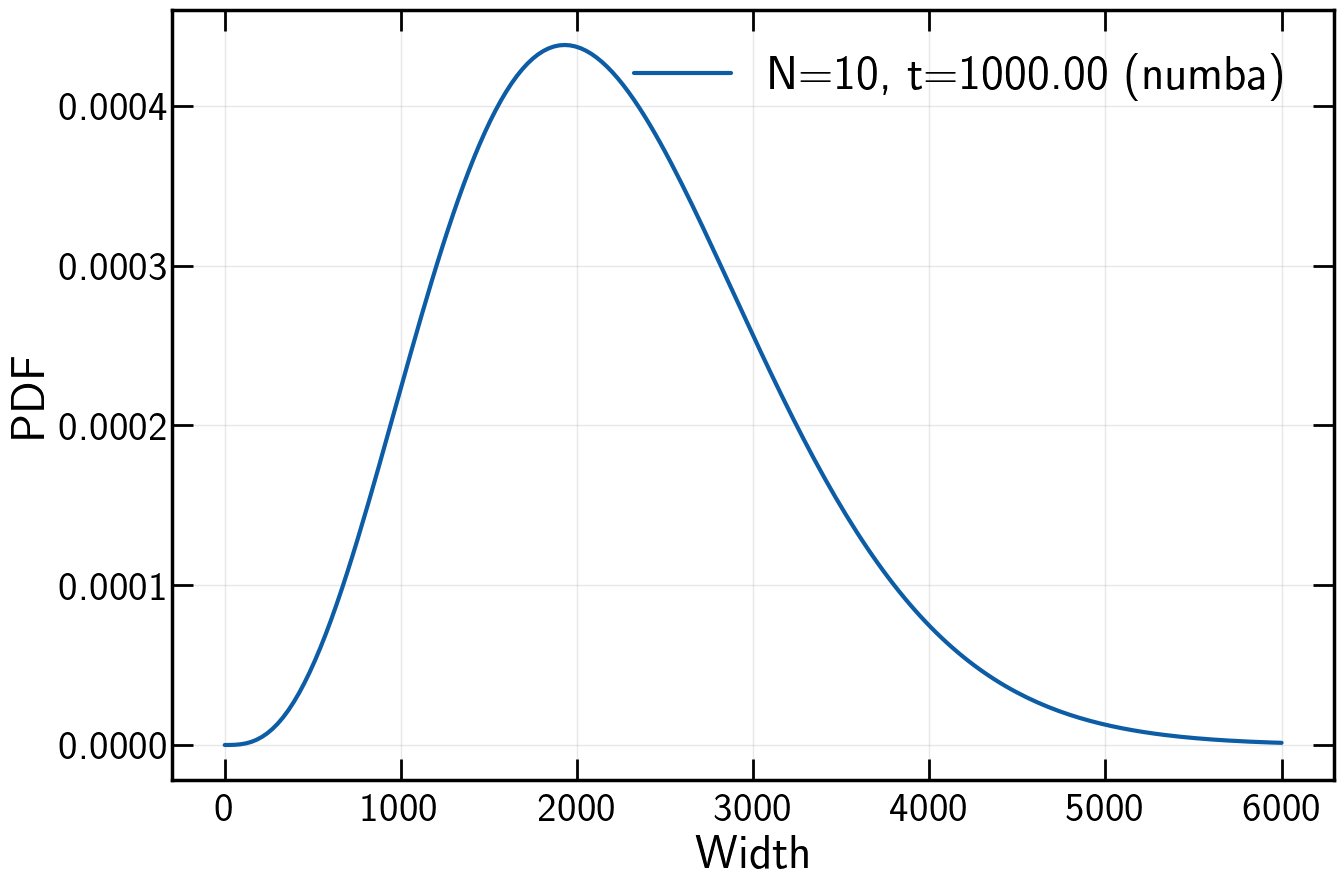

CPU times: user 3.16 s, sys: 502 ms, total: 3.66 s
Wall time: 3.62 s


(array([   0.        ,   30.15075402,   60.30150804,   90.45226206,
         120.60301608,  150.7537701 ,  180.90452412,  211.05527814,
         241.20603216,  271.35678618,  301.5075402 ,  331.65829422,
         361.80904824,  391.95980226,  422.11055629,  452.26131031,
         482.41206433,  512.56281835,  542.71357237,  572.86432639,
         603.01508041,  633.16583443,  663.31658845,  693.46734247,
         723.61809649,  753.76885051,  783.91960453,  814.07035855,
         844.22111257,  874.37186659,  904.52262061,  934.67337463,
         964.82412865,  994.97488267, 1025.12563669, 1055.27639071,
        1085.42714473, 1115.57789875, 1145.72865277, 1175.87940679,
        1206.03016081, 1236.18091483, 1266.33166886, 1296.48242288,
        1326.6331769 , 1356.78393092, 1386.93468494, 1417.08543896,
        1447.23619298, 1477.386947  , 1507.53770102, 1537.68845504,
        1567.83920906, 1597.98996308, 1628.1407171 , 1658.29147112,
        1688.44222514, 1718.59297916, 1748.74373

In [3]:
%%time

# Plot a 1D PDF at drift time=200 µs and N=5 electrons
model.plot_pdf_1d_numba(n=10, drift_time=5, widths=widths)
model.plot_pdf_1d_numba(n=10, drift_time=200, widths=widths)
model.plot_pdf_1d_numba(n=10, drift_time=1000, widths=widths)

69.18802099005802
CPU times: user 1.56 s, sys: 190 ms, total: 1.75 s
Wall time: 251 ms


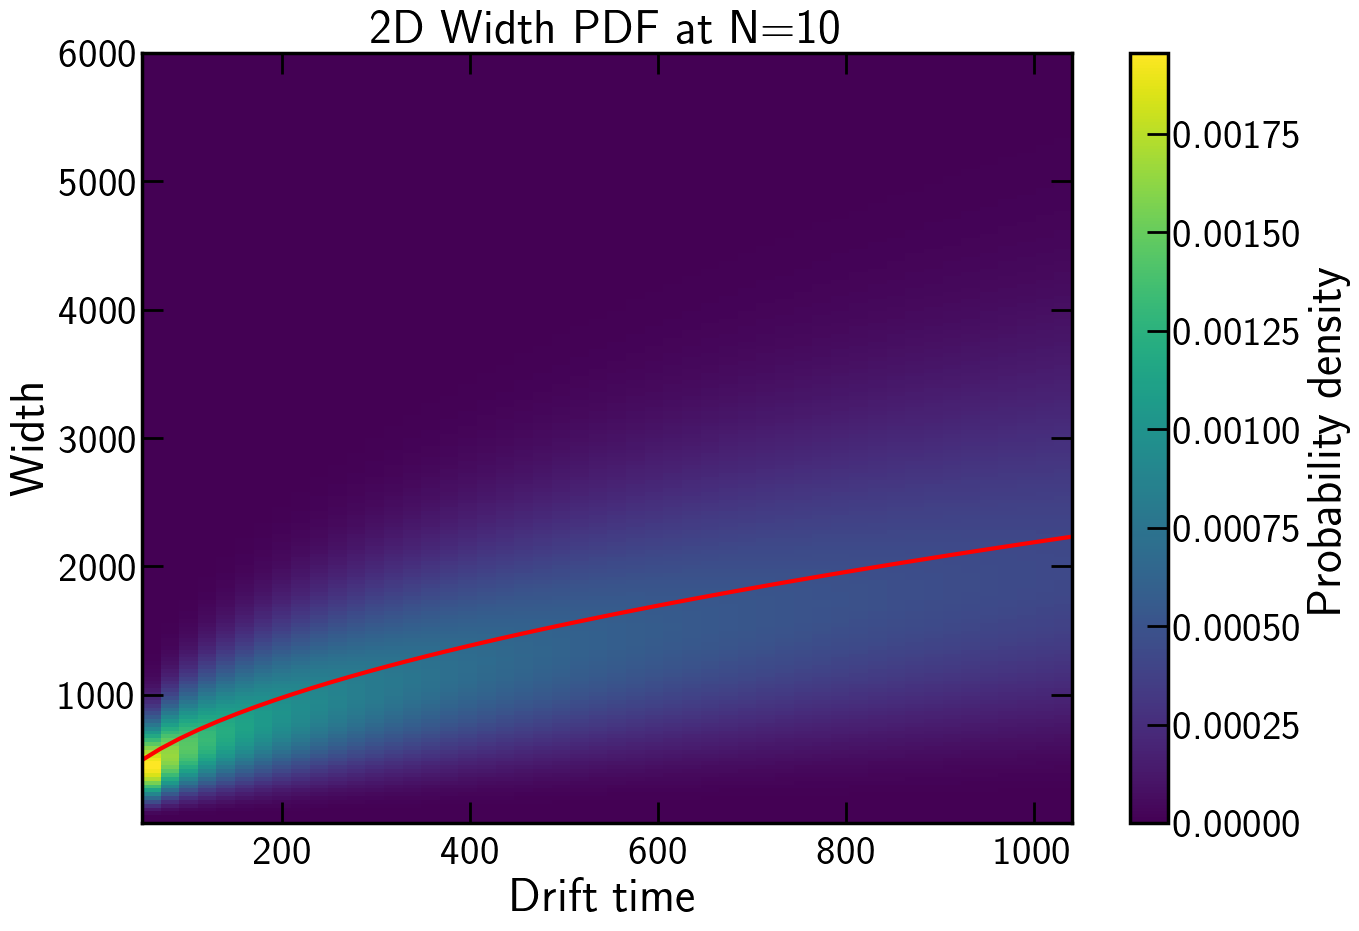

In [4]:
%%time

print(model.M)

# Plot a 2D PDF slice at fixed N=10 electrons
drift_times = np.linspace(50, 1040, 50)
model.plot_pdf_2d(n=10, drift_times=drift_times, widths=widths)
plt.plot(drift_times, np.sqrt(model.M**2*drift_times + C**2), color='red')

In [5]:
model.build_pdf_3d(n_values=np.arange(4,21), drift_times=np.linspace(50,1040,50))

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

In [6]:
# Compute and store 1%-99% bounds
model.lower_bounds, model.upper_bounds = WidthModel.compute_percentile_bounds(
    model.pdf_3d, model._pdf_widths, lower=2, upper=98.0
)

In [7]:
%%time

M = 10000  # number of events

Ns = np.random.uniform(4, 20, size=M)
DTs = np.random.uniform(50,1040,size=M)

Ws = model.sample(Ns, DTs)

CPU times: user 12.1 s, sys: 4.71 ms, total: 12.2 s
Wall time: 12.1 s


<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_3014/3211135782.py:13: SyntaxWarning: invalid escape sequence '\%'
  plt.plot(model._pdf_drift_times, model.lower_bounds[n_idx, :], 'b--', label="2\% and 98\% contour")


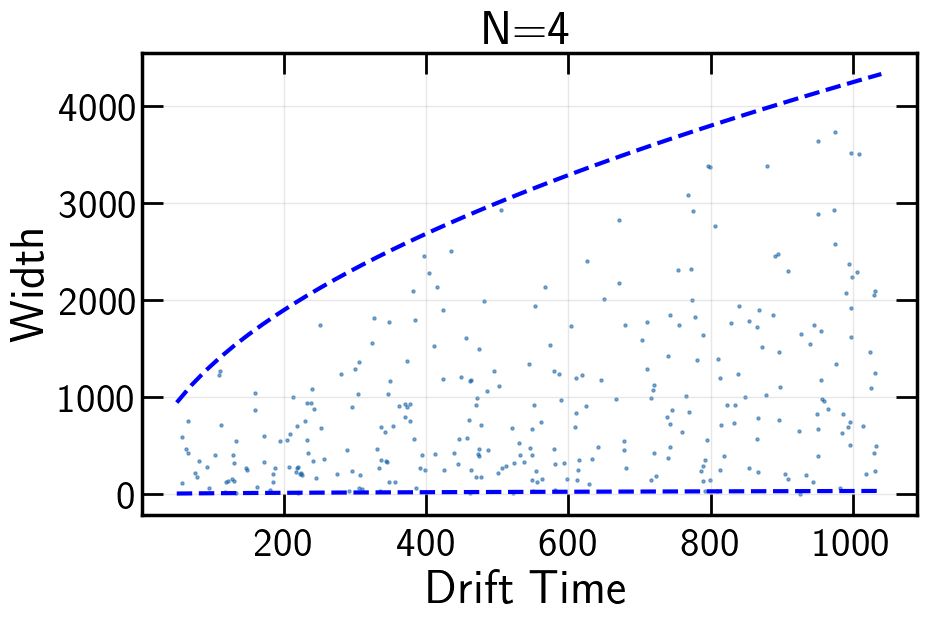

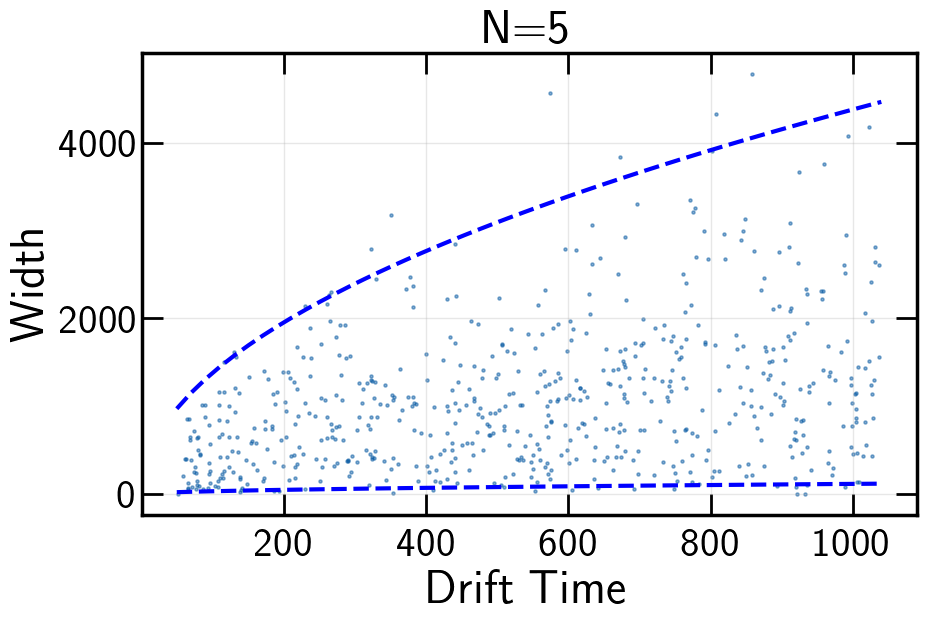

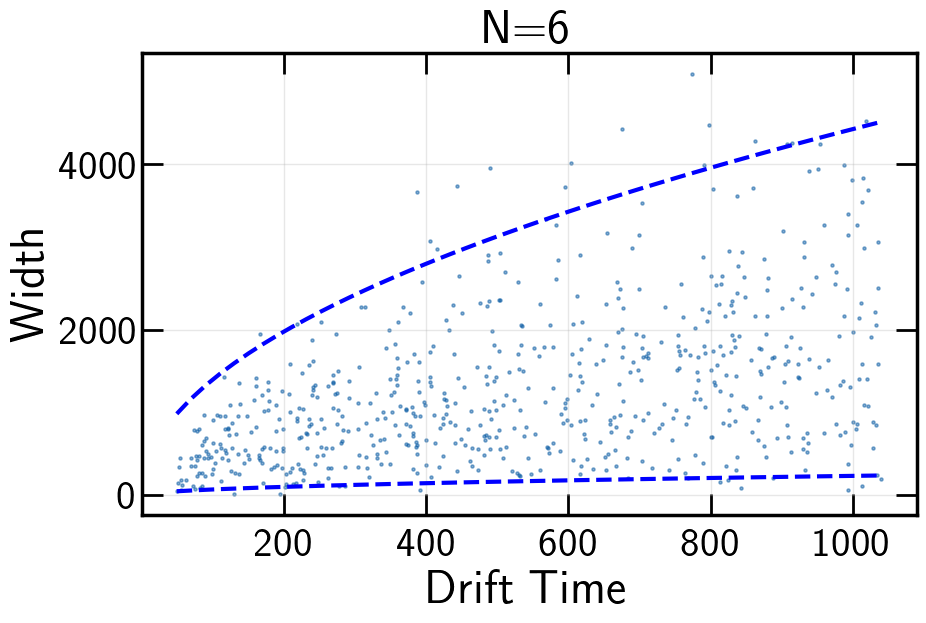

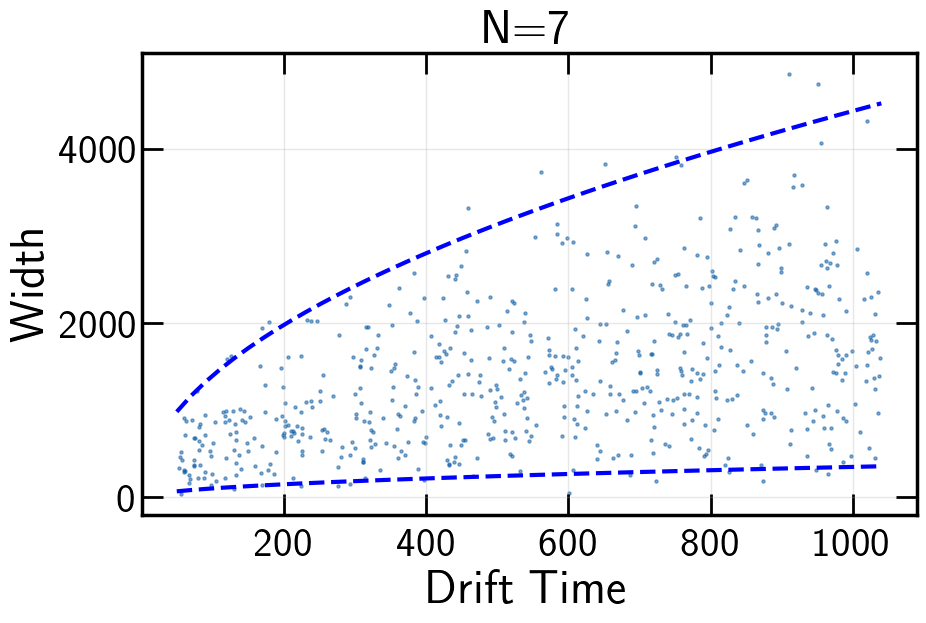

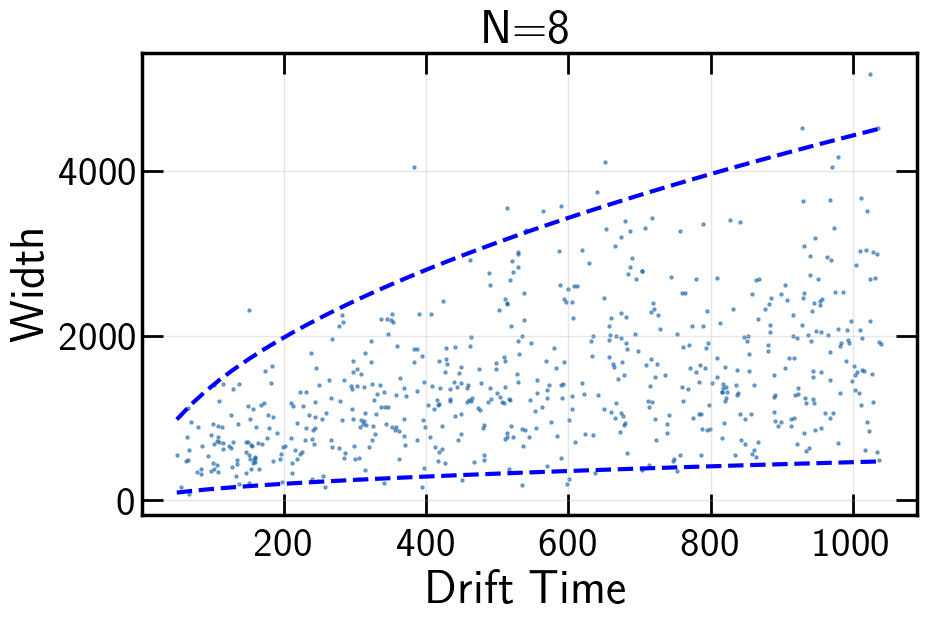

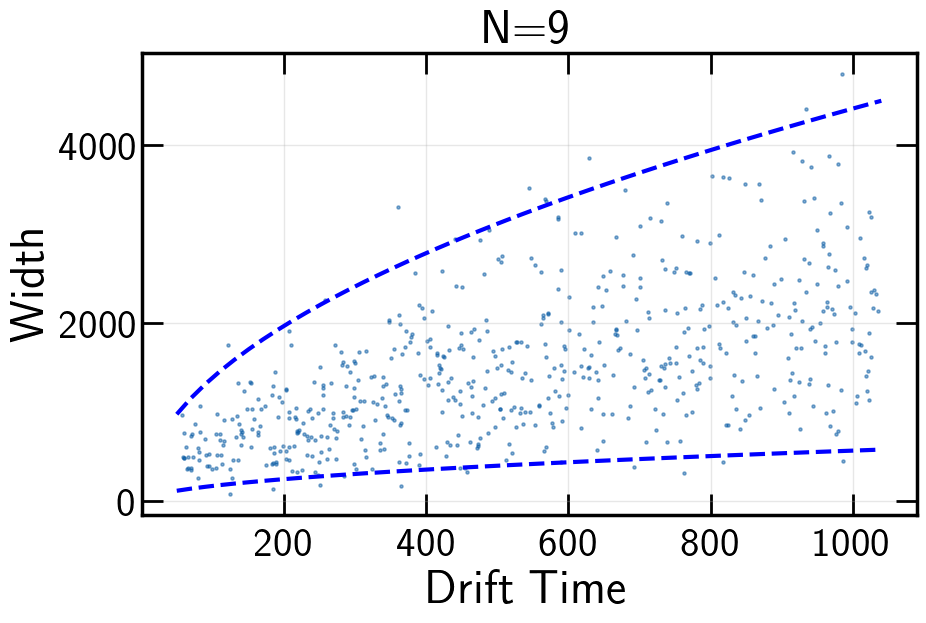

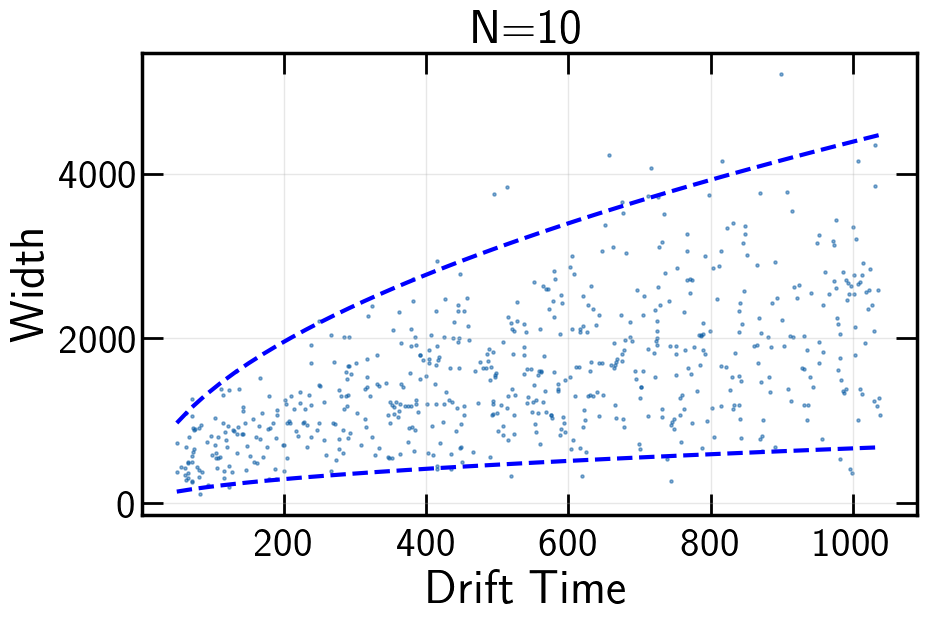

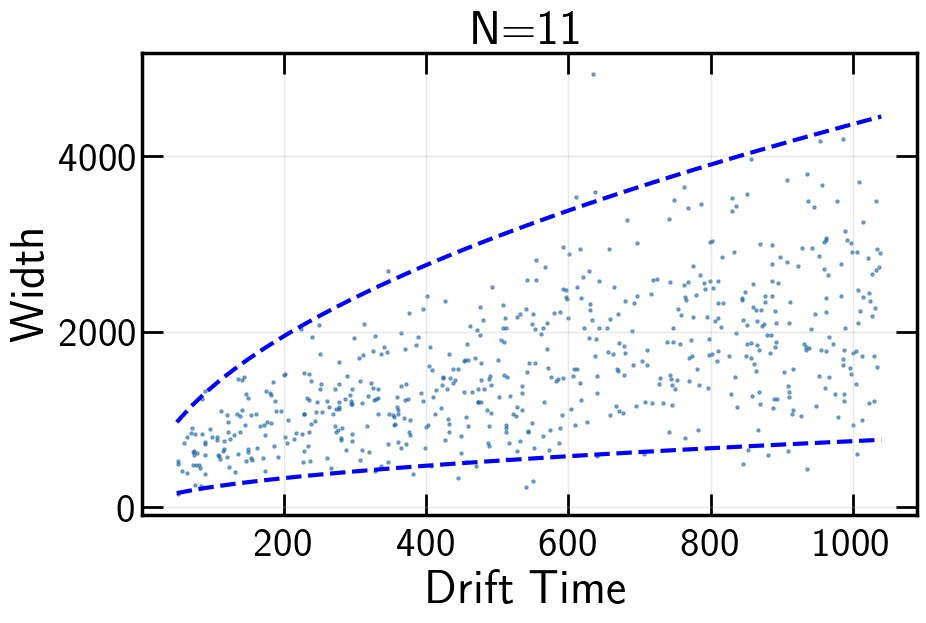

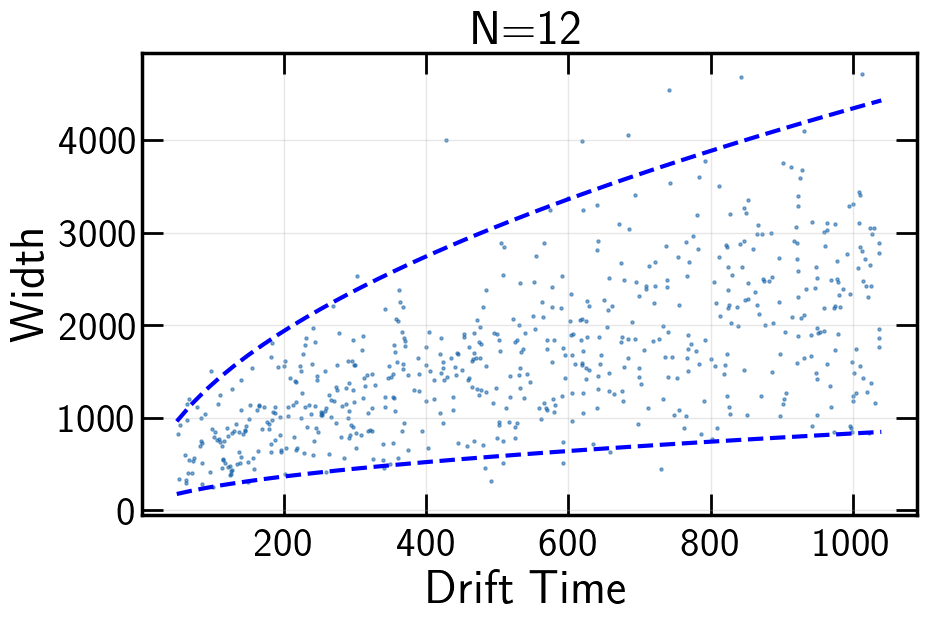

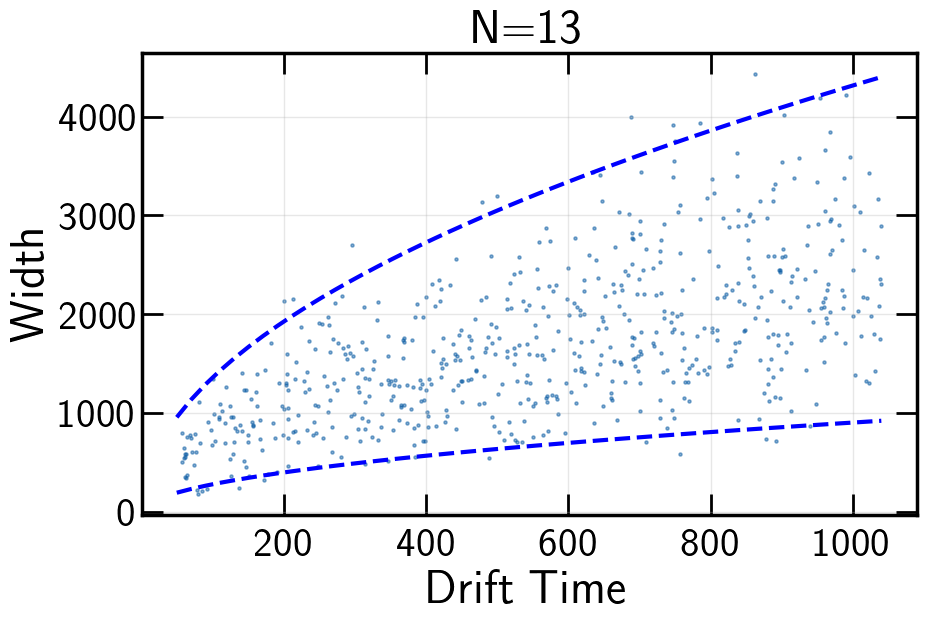

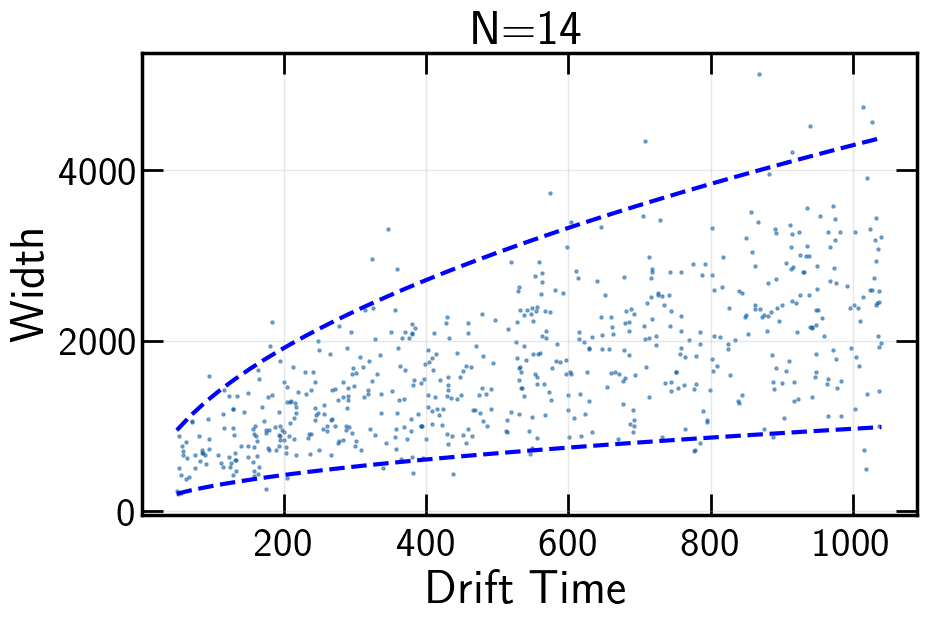

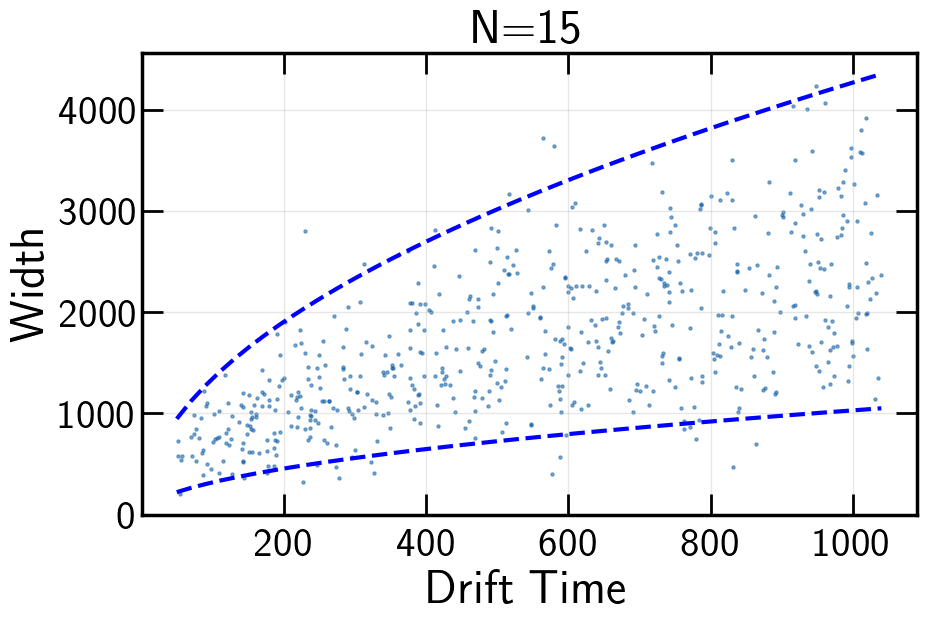

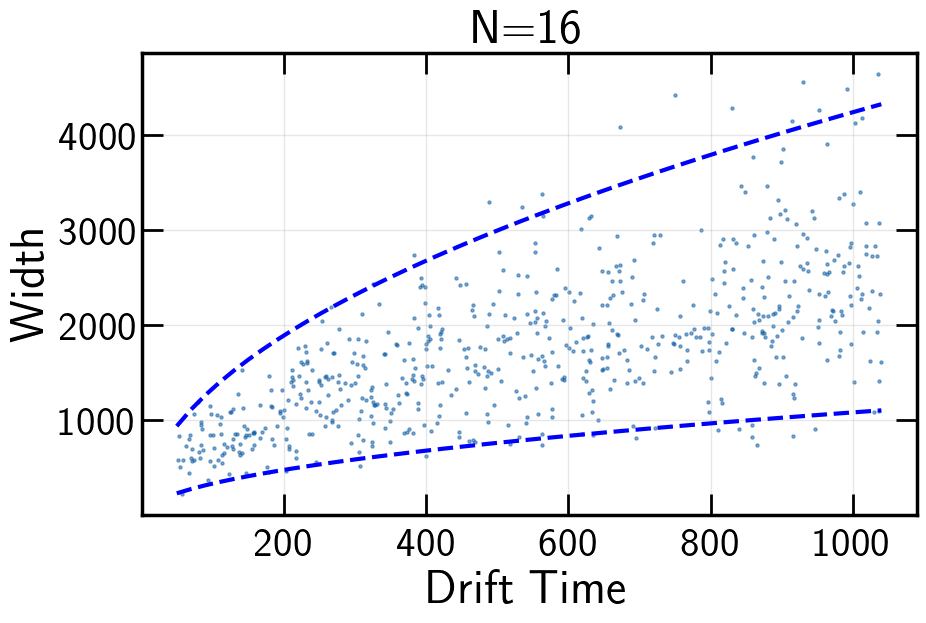

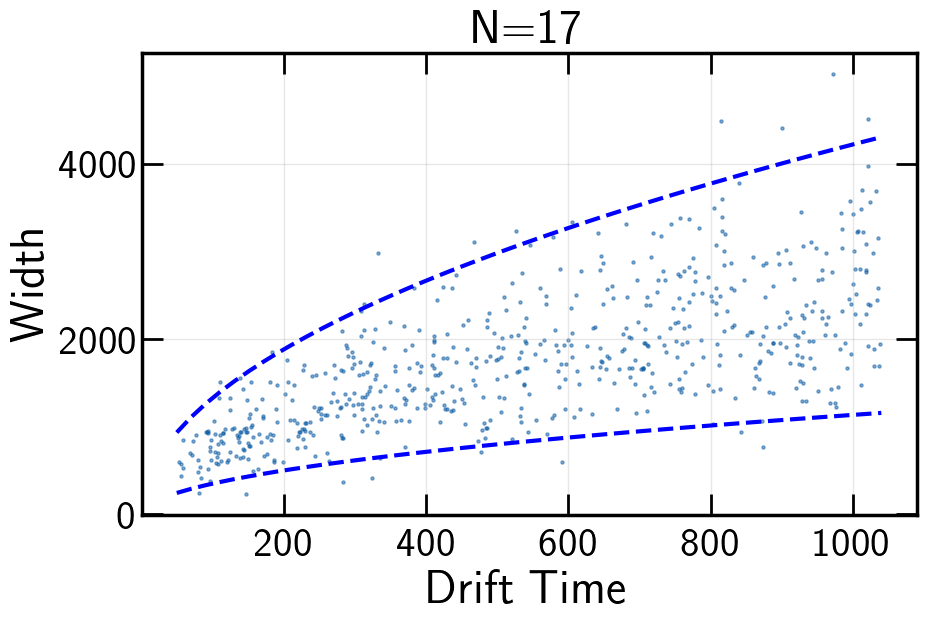

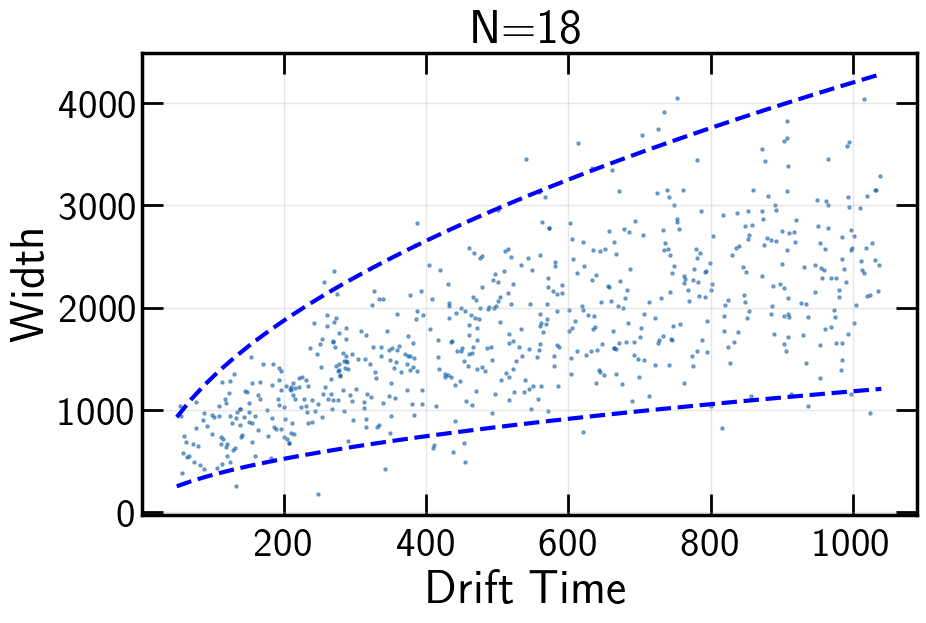

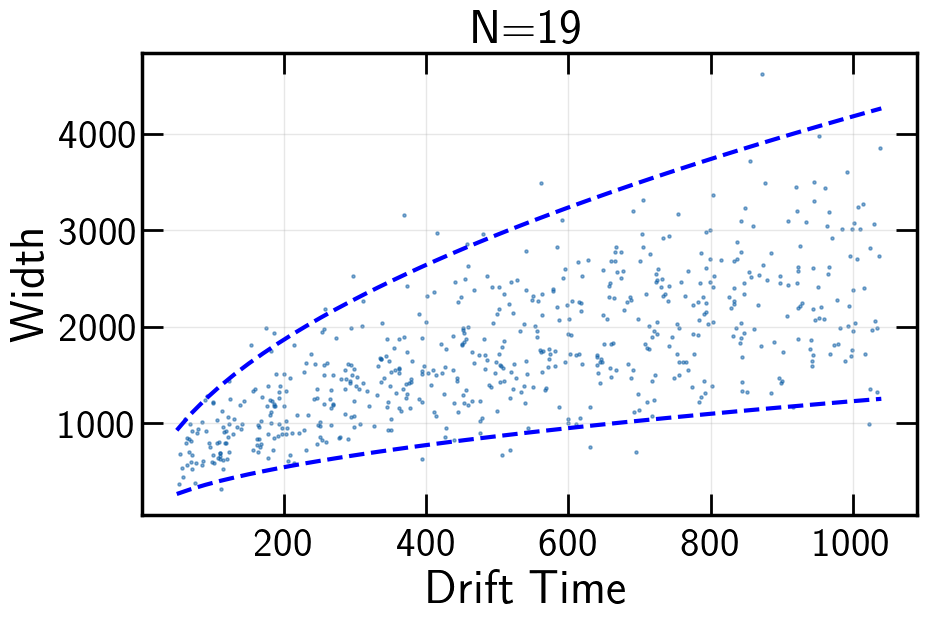

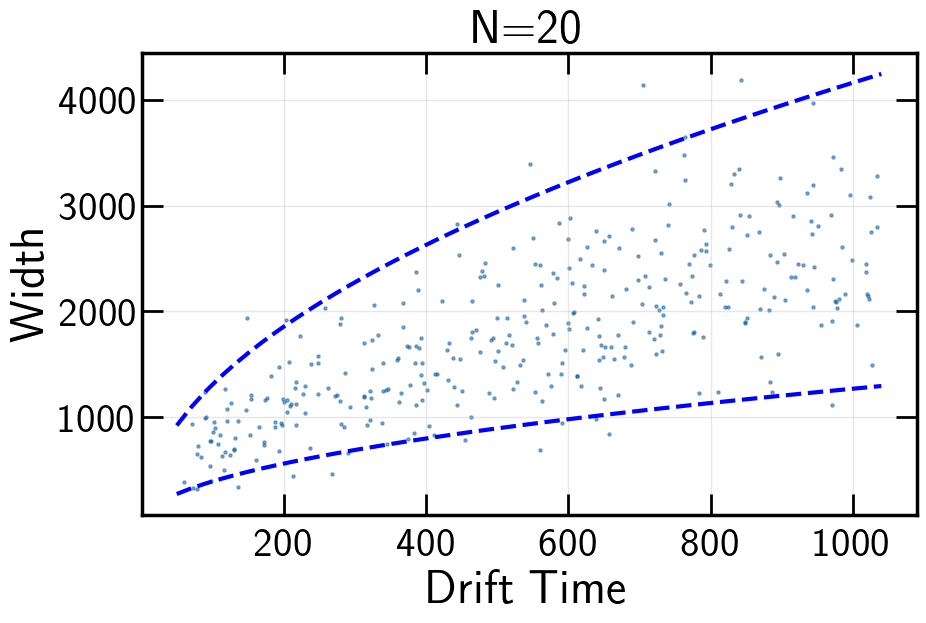

In [8]:
unique_Ns = np.unique(np.rint(Ns).astype(int))
Ns_rounded = np.rint(Ns).astype(int)

for n_val in unique_Ns:
    mask = Ns_rounded == n_val
    plt.figure(figsize=(10, 6))
    plt.scatter(DTs[mask], Ws[mask], s=5, alpha=0.5, label="Samples")

    # Use stored axes in the model
    n_idx = np.argmin(np.abs(model._pdf_n_values - n_val))

    # Plot 1% and 99% contours
    plt.plot(model._pdf_drift_times, model.lower_bounds[n_idx, :], 'b--', label="2\% and 98\% contour")
    plt.plot(model._pdf_drift_times, model.upper_bounds[n_idx, :], 'b--')

    plt.xlabel("Drift Time")
    plt.ylabel("Width")
    plt.title(f"N={n_val}")
    plt.grid(True, alpha=0.3)


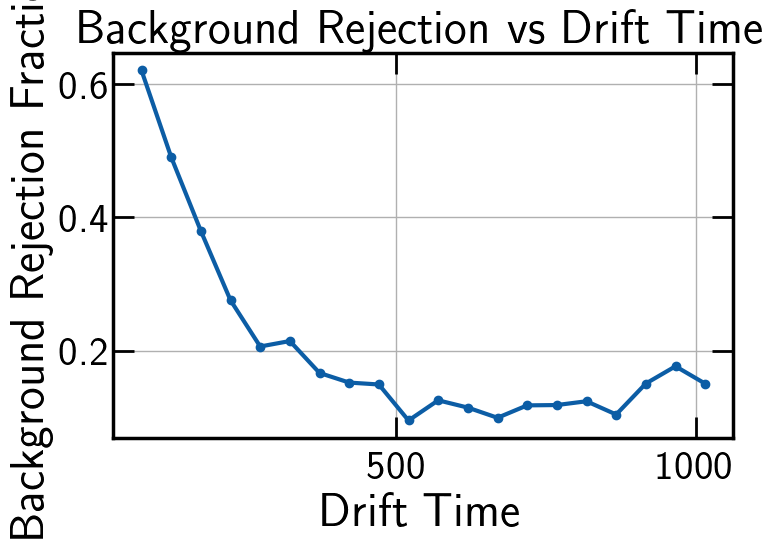

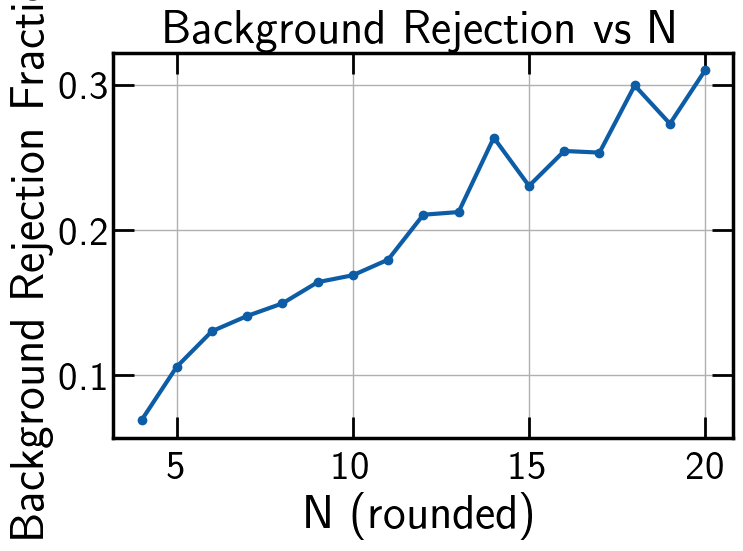

In [9]:
drift_times_proxy = np.random.uniform(
    model._pdf_drift_times[0], model._pdf_drift_times[-1], size=len(Ns)
)

outside_mask = np.zeros(M, dtype=bool)

for i in range(M):
    N_event = int(round(Ns[i]))
    # Find nearest index for N in the model
    n_idx = np.argmin(np.abs(model._pdf_n_values - N_event))
    # Interpolate lower and upper bounds along drift time
    lower_interp = interp1d(model._pdf_drift_times, model.lower_bounds[n_idx, :],
                            bounds_error=False, fill_value=(model._pdf_widths[0], model._pdf_widths[-1]))
    upper_interp = interp1d(model._pdf_drift_times, model.upper_bounds[n_idx, :],
                            bounds_error=False, fill_value=(model._pdf_widths[0], model._pdf_widths[-1]))
    lower_bound = lower_interp(drift_times_proxy[i])
    upper_bound = upper_interp(drift_times_proxy[i])
    
    outside_mask[i] = (Ws[i] < lower_bound) or (Ws[i] > upper_bound)
    
num_bins_dt = 20
dt_bins = np.linspace(model._pdf_drift_times[0], model._pdf_drift_times[-1], num_bins_dt + 1)
dt_centers = 0.5 * (dt_bins[:-1] + dt_bins[1:])
rejection_vs_dt = np.zeros(num_bins_dt)

for j in range(num_bins_dt):
    mask = (drift_times_proxy >= dt_bins[j]) & (drift_times_proxy < dt_bins[j+1])
    if np.any(mask):
        rejection_vs_dt[j] = np.mean(outside_mask[mask])
    else:
        rejection_vs_dt[j] = np.nan

plt.figure(figsize=(8, 5))
plt.plot(dt_centers, rejection_vs_dt, marker='o')
plt.xlabel("Drift Time")
plt.ylabel("Background Rejection Fraction")
plt.title("Background Rejection vs Drift Time")
plt.grid(True)

unique_Ns_rounded = np.unique(np.rint(Ns).astype(int))
rejection_vs_N = np.zeros_like(unique_Ns_rounded, dtype=float)

for k, n_val in enumerate(unique_Ns_rounded):
    mask = np.rint(Ns).astype(int) == n_val
    if np.any(mask):
        rejection_vs_N[k] = np.mean(outside_mask[mask])
    else:
        rejection_vs_N[k] = np.nan
        
plt.figure(figsize=(8, 5))
plt.plot(unique_Ns_rounded, rejection_vs_N, marker='o')
plt.xlabel("N (rounded)")
plt.ylabel("Background Rejection Fraction")
plt.title("Background Rejection vs N")
plt.grid(True)
plt.show()